# PTC3467

*By Daniel Deutsch and Diogo Mendonça*

In [10]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

In [11]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

## Import Data

The datasets used in this project can be found at https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study. Once both csv files are downloaded, they are locally stored in the computer, where the pandas library can easily access it and create the corresponding dataframes.

In [3]:
df_math = pd.read_csv("./datasets/raw/Maths.csv")
df_pt = pd.read_csv("./datasets/raw/Portuguese.csv")

## Data Pre-Processing

The first thing done in the datasets is some sort of "data processing" to facilitate the usage of the dataframe. 

### Merges the Dataframes

In [4]:
# Concatenates the datasets
df_math['subject'] = "Math"
df_pt['subject'] = "Portuguese"
df = pd.concat([df_math, df_pt], ignore_index=True)
del df_math, df_pt

### Creates the Target Variable

In [5]:
# Creates the target variable
df['status'] = df['G3'] >= 10
df['status'] = df['status'].replace({True: "Approved", False: "Failed"})

### Label Encoder

In [6]:
le_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'subject', 'status']

for feature in le_features:
    le = LabelEncoder().fit(df[feature])
    df[feature] = le.transform(df[feature])
    print(feature + (15-len(feature))*" " + str(dict(zip(le.classes_, le.transform(le.classes_)))))

school         {'GP': 0, 'MS': 1}
sex            {'F': 0, 'M': 1}
address        {'R': 0, 'U': 1}
famsize        {'GT3': 0, 'LE3': 1}
Pstatus        {'A': 0, 'T': 1}
Mjob           {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4}
Fjob           {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4}
reason         {'course': 0, 'home': 1, 'other': 2, 'reputation': 3}
guardian       {'father': 0, 'mother': 1, 'other': 2}
schoolsup      {'no': 0, 'yes': 1}
famsup         {'no': 0, 'yes': 1}
paid           {'no': 0, 'yes': 1}
activities     {'no': 0, 'yes': 1}
nursery        {'no': 0, 'yes': 1}
higher         {'no': 0, 'yes': 1}
internet       {'no': 0, 'yes': 1}
romantic       {'no': 0, 'yes': 1}
subject        {'Math': 0, 'Portuguese': 1}
status         {'Approved': 0, 'Failed': 1}


### Feature and Label Split 

In [7]:
# Obtains the explainable features
X = df.drop(columns=['G1', 'G2', 'G3', 'status'], axis=1)

# Obtains the classification label
y_clf = df['status'].values.ravel()

# Obtains the regression explained feature
y_reg = df['G3'].values.ravel()

## Exploratory Analysis

This part of the study is very important. This is the moment when we understand how each variable interact with each other, which are the important features for the machine learning model and, of course, allows us to make some inferences about the students behaviour.

The first thing to do here is to separate the categorical features from the numerical ones.

In [102]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
            'Walc', 'health', 'absences', 'subject']

# Features by type
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerical_features = ['age', 'Medu' ]

# Features by theme
socioeconomic_features = ['sex', 'address', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'famsize', 'famrel', 'traveltime', 'schoolsup', 'famsup', 'paid', 'internet', 'freetime']

### Relationship Between Categorical Features and Target Variable

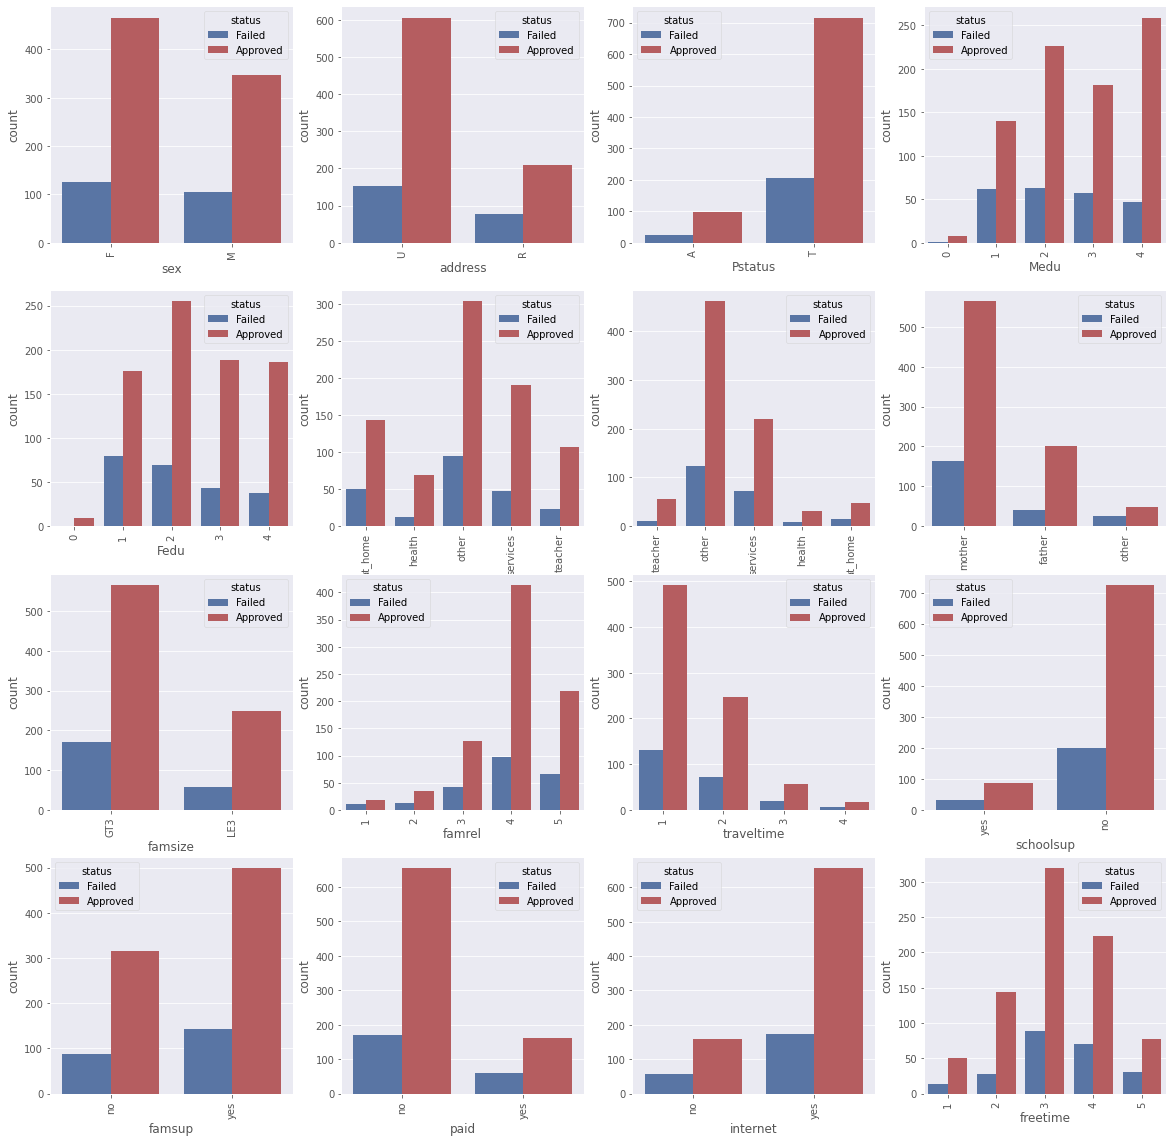

In [32]:
_, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(socioeconomic_features):
    ax = sns.countplot(x=feature, hue='status', data=df, ax=axs[i//4, i%4], log=False)
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

### Pairplot

The pairplot is a very interesting plot that shows how the features of the dataset interact with each other. 

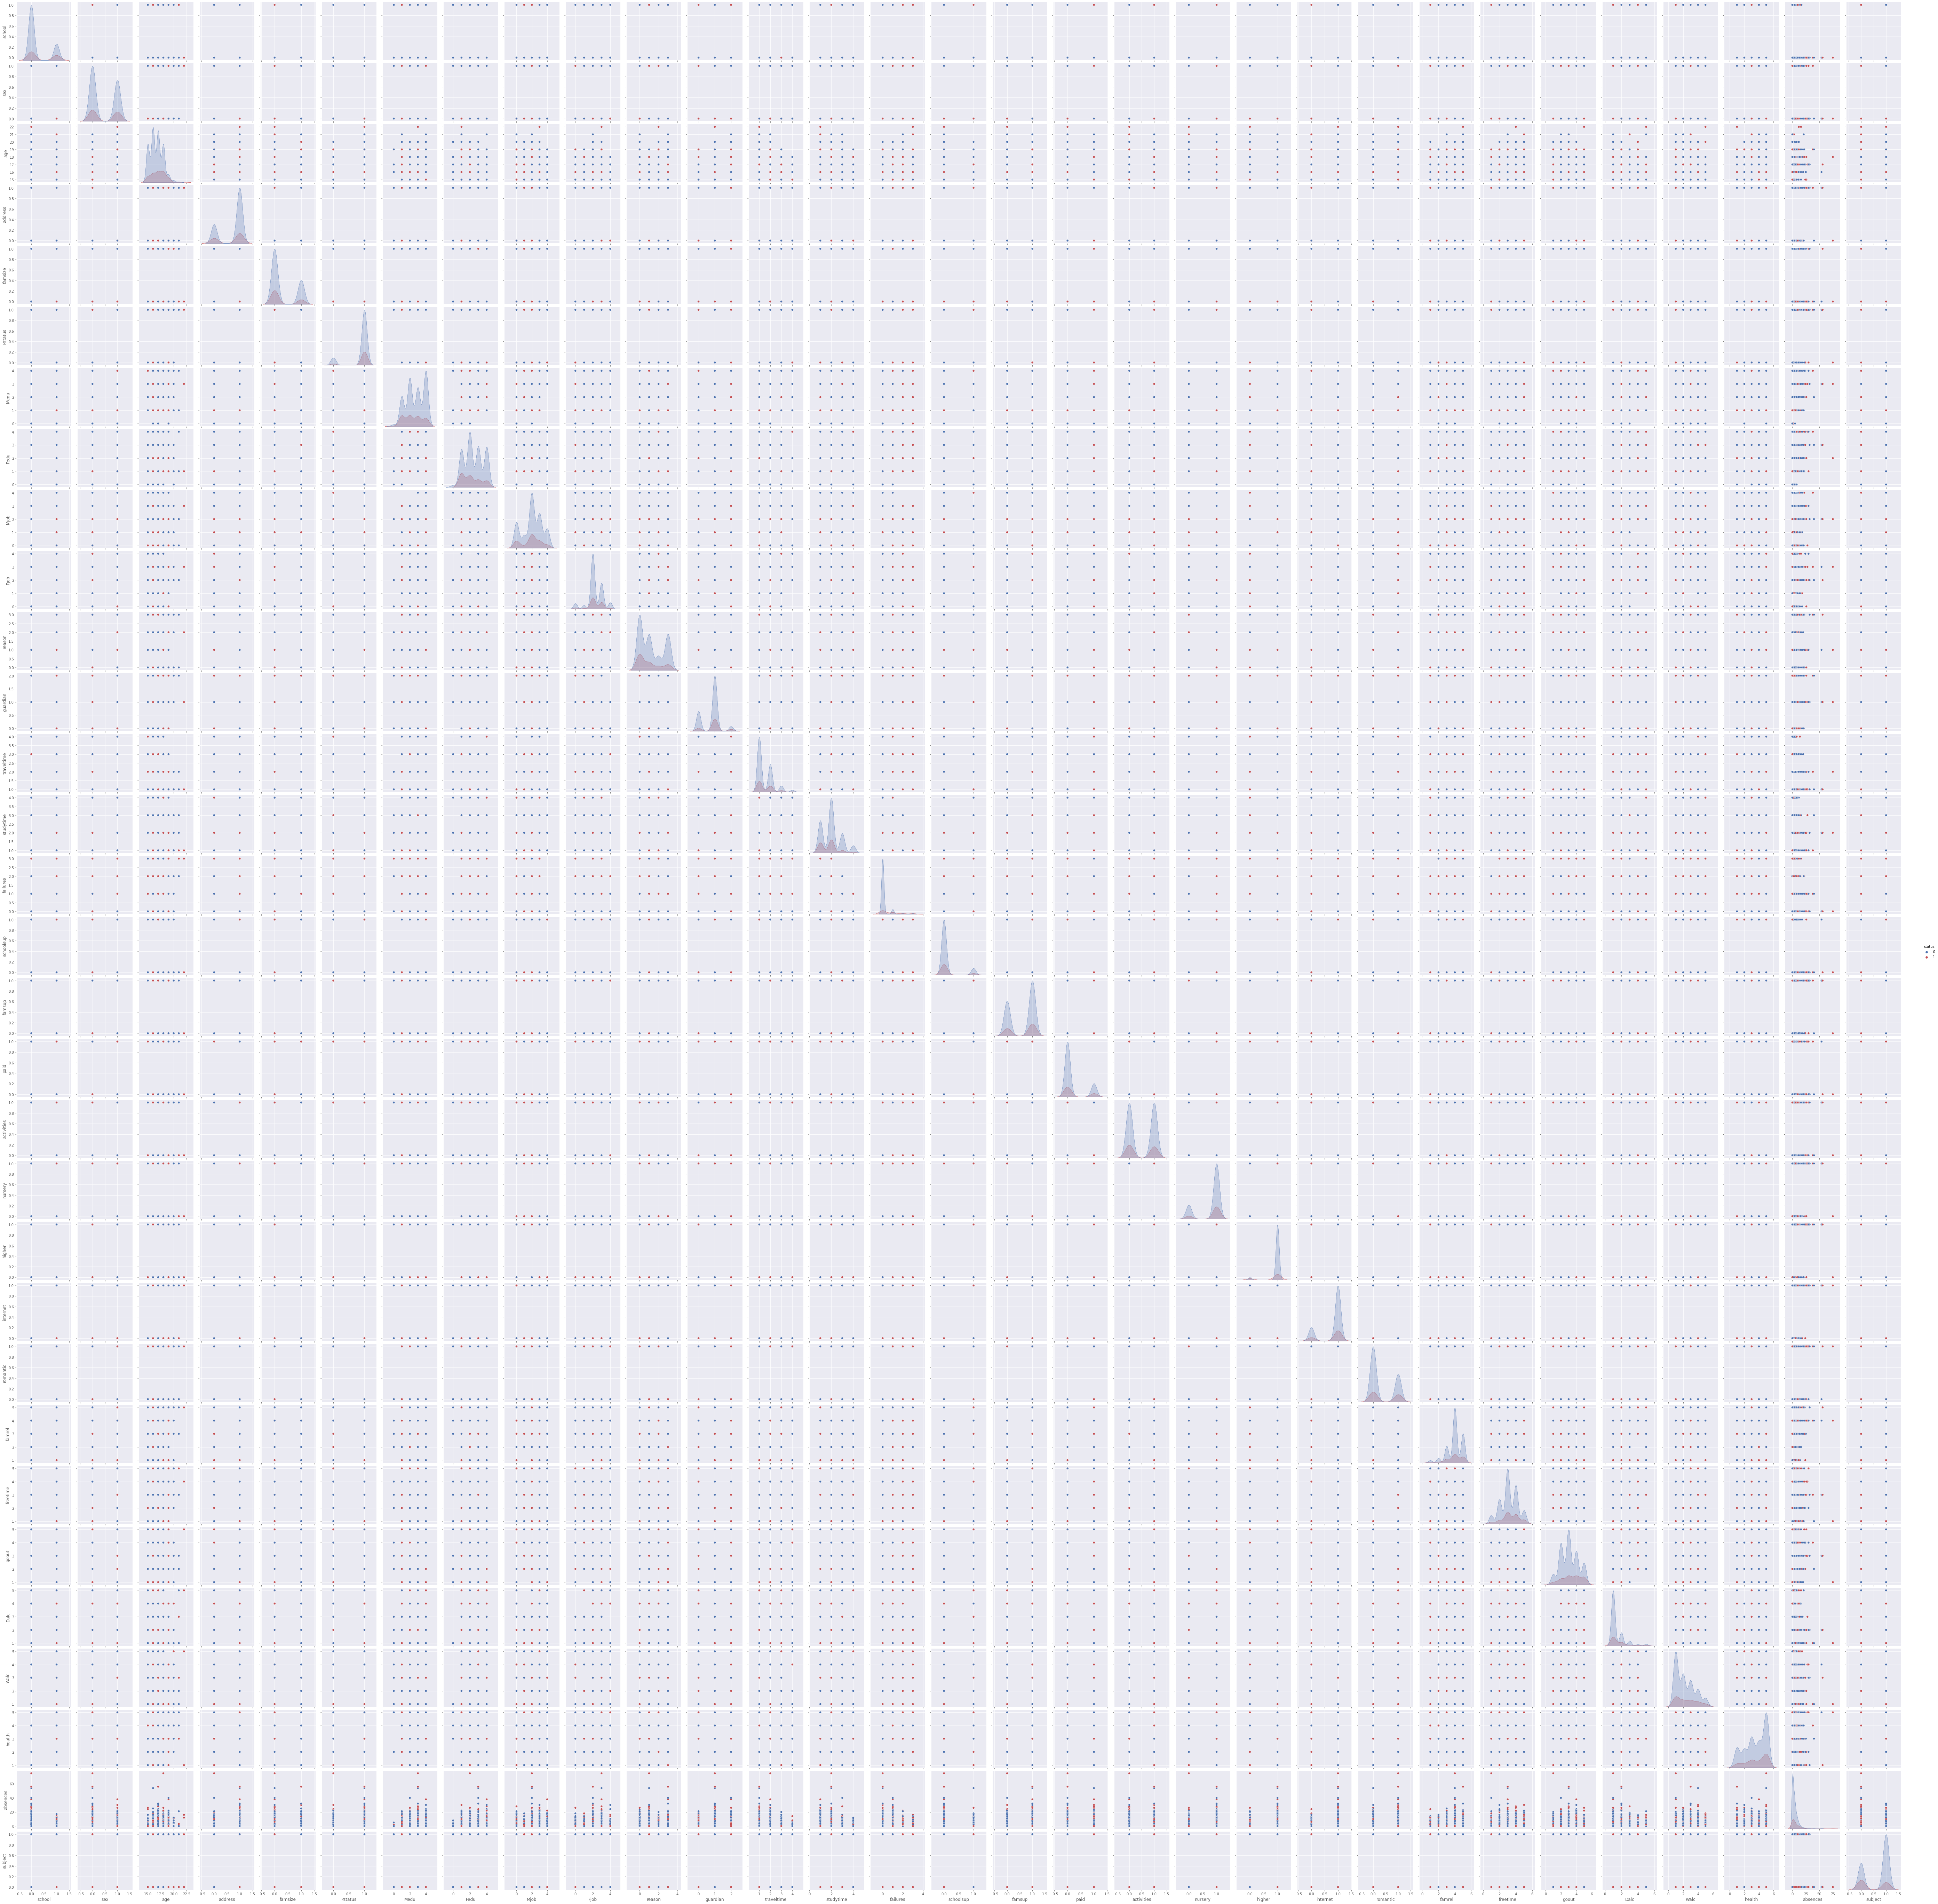

In [103]:
sns.pairplot(df[features + ['status']], hue='status')
plt.show()

### Correlation Matrix

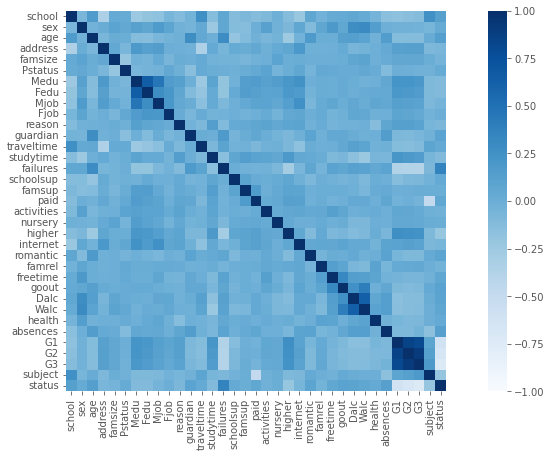

In [48]:
sns.heatmap(df.corr(), square=True, annot=False, vmin=-1, vmax=1, cmap='Blues')
plt.show()

### Feature Importance

#### Principal Component Analysis

Principal Component Analysis (PCA) is an algorithm used for dimmensionality reduction.

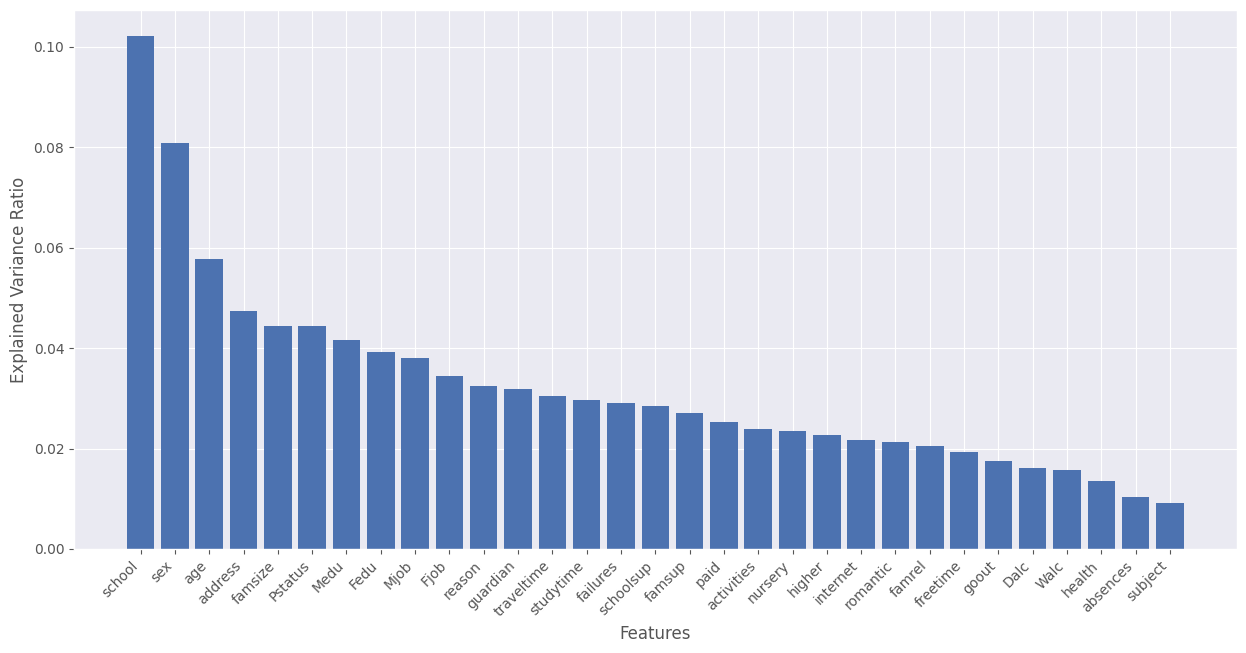

In [16]:
# Standardizes the data
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
X_standard = pd.DataFrame(X_standard, columns=X.columns)

# Builds and fits the pca
pca = PCA()
pca.fit(X_standard)

# Plots the feature's singular values
plt.bar(pca.feature_names_in_, pca.explained_variance_ratio_)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Features")
plt.show()

## Prediction Models

### Classification Models

At this stage of the project, the goal is to predict the status label of the dataset. In other words, we want to understand if we are able to predict whether the student is going to be approved or not on the subject given his/hers social features. 

In [45]:
# Train Test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.3, random_state=0)

# Defines a summary dataframe
df_clf = pd.DataFrame()

#### Logistic Regression (Benchmark)

In [46]:
# Builds the classifier
clf = LogisticRegression()

# Sets the testing params for the grid search
params = { 
    'penalty': ['l1','l2'],
    'C': np.logspace(-3, 3, 7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

# Builds and fits the grid
grid = GridSearchCV(clf, params, scoring='accuracy', cv=10)
grid.fit(X_train_clf, y_train_clf)

# Saves the results
df_tmp = pd.DataFrame([{ 'model': "Logistic Regression", 'accuracy': grid.best_score_, 'params': grid.best_params_, 'clf': grid.best_estimator_}])
df_clf = pd.concat([df_clf, df_tmp], ignore_index=True)

print(f"Model: Logistic Regression, Accuracy: {grid.best_score_}, Params: {grid.best_params_}")

Model: Logistic Regression, Accuracy: 0.7917808219178081, Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


#### Support Vector Machine

In [48]:
# Builds the classifier
clf = SVC(probability=True)

# Sets the testing params for the grid search
params = { 
    'C': np.logspace(-3, 2, 6),
    'gamma': np.logspace(-4, 0, 5),
    'kernel': ['rbf']
}

# Builds and fits the grid
grid = GridSearchCV(clf, params, scoring='accuracy', cv=10)
grid.fit(X_train_clf, y_train_clf)

# Saves the results
df_tmp = pd.DataFrame([{ 'model': "SVM", 'accuracy': grid.best_score_, 'params': grid.best_params_, 'clf': grid.best_estimator_}])
df_clf = pd.concat([df_clf, df_tmp], ignore_index=True)

print(f"Model: SVM, Accuracy: {grid.best_score_}, Params: {grid.best_params_}")

Model: SVM, Accuracy: 0.7904109589041096, Params: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


#### Random Forest

In [49]:
# Builds the classifier
clf = RandomForestClassifier()

# Sets the testing params for the grid search
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

# Builds and fits the grid
grid = GridSearchCV(clf, params, scoring='accuracy', cv=10)
grid.fit(X_train_clf, y_train_clf)

# Saves the results
df_tmp = pd.DataFrame([{ 'model': "Random Forest", 'accuracy': grid.best_score_, 'params': grid.best_params_, 'clf': grid.best_estimator_}])
df_clf = pd.concat([df_clf, df_tmp], ignore_index=True)

print(f"Model: Random Forest, Accuracy: {grid.best_score_}, Params: {grid.best_params_}")

Model: Random Forest, Accuracy: 0.7945205479452054, Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}


#### Model Comparison

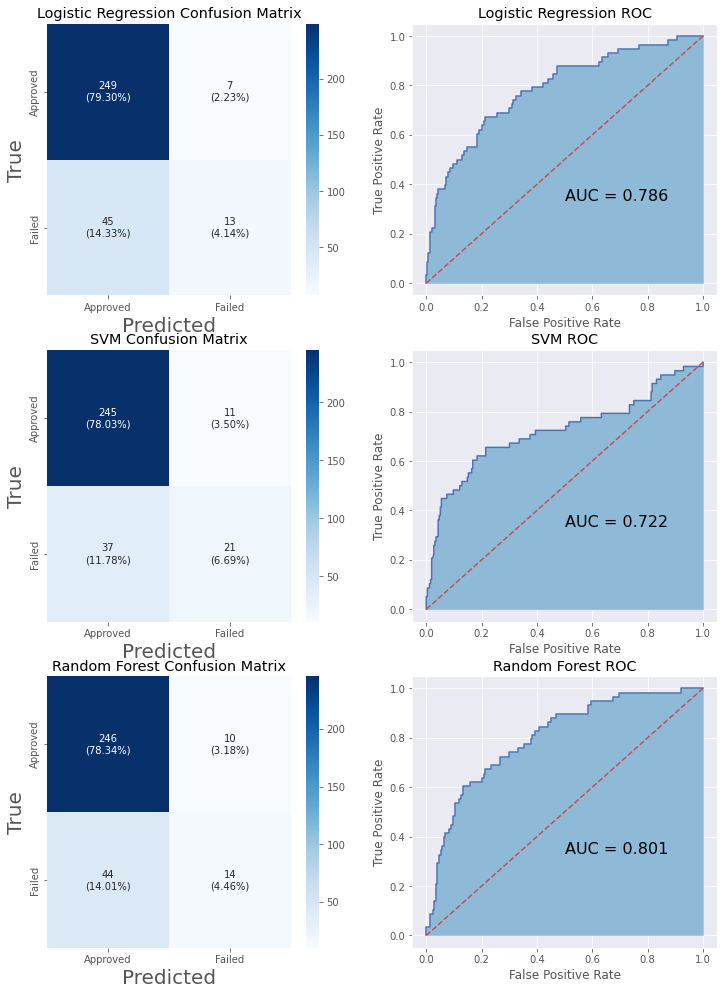

In [59]:
fig, axs = plt.subplots(3, 2, figsize=(12, 17))

for i, row in df_clf.iterrows():

    # Gets features
    clf = row['clf']
    model = row['model']
    
    # Estimates the test set
    y_test_clf_pred = clf.predict(X_test_clf)
    y_test_clf_pred_scores = clf.predict_proba(X_test_clf)[:, 1]

    # Plots the confusion matrix
    cf_matrix = confusion_matrix(y_test_clf, y_test_clf_pred)
    counts = [ f"{val:0.0f}" for val in cf_matrix.flatten() ]
    pcts = [ f"{100*val:.2f}" for val in cf_matrix.flatten()/np.sum(cf_matrix) ]
    annot = np.asarray([ f"{count}\n({pct}%)" for count, pct in zip(counts, pcts) ]).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=annot, cmap='Blues', fmt='', ax=axs[i, 0])
    axs[i, 0].set_title(f"{model} Confusion Matrix")
    axs[i, 0].set_ylabel("True", fontsize=20)
    axs[i, 0].set_xlabel("Predicted", fontsize=20)
    axs[i, 0].xaxis.set_ticklabels(['Approved', 'Failed'], fontsize=10) 
    axs[i, 0].yaxis.set_ticklabels(['Approved', 'Failed'], fontsize=10)

    # Plots the ROC
    fpr, tpr, thresholds = roc_curve(y_test_clf, y_test_clf_pred_scores)
    axs[i, 1].plot(fpr, tpr)
    axs[i, 1].plot([0, 1], [0, 1], linestyle="--")
    filled_part = axs[i, 1].fill_between(fpr, tpr, color='#8EB9D7')
    (x0, y0), (x1, y1) = filled_part.get_paths()[0].get_extents().get_points()
    axs[i, 1].text(x1/2, y1/3, f"AUC = {roc_auc_score(y_test_clf, y_test_clf_pred_scores):.3f}", fontsize=16)
    axs[i, 1].set_title(f"{model} ROC")
    axs[i, 1].set_xlabel("False Positive Rate")
    axs[i, 1].set_ylabel("True Positive Rate")

plt.show()